Total tiles: 252
Tiles to process: 81
Tiles ignored (black): 171


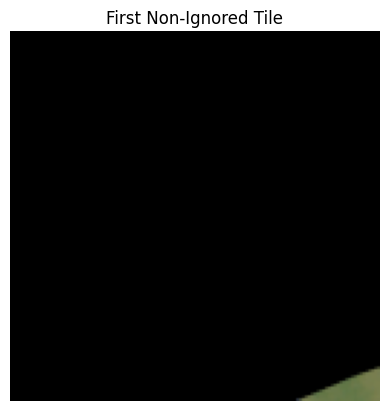

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

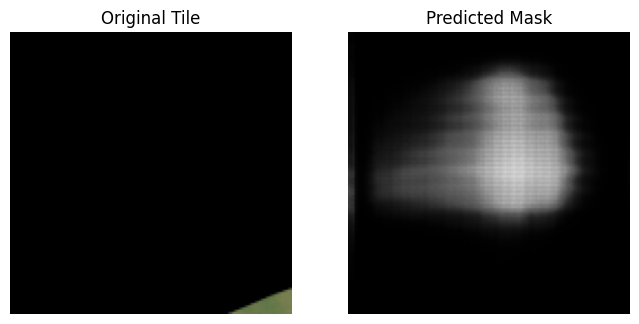

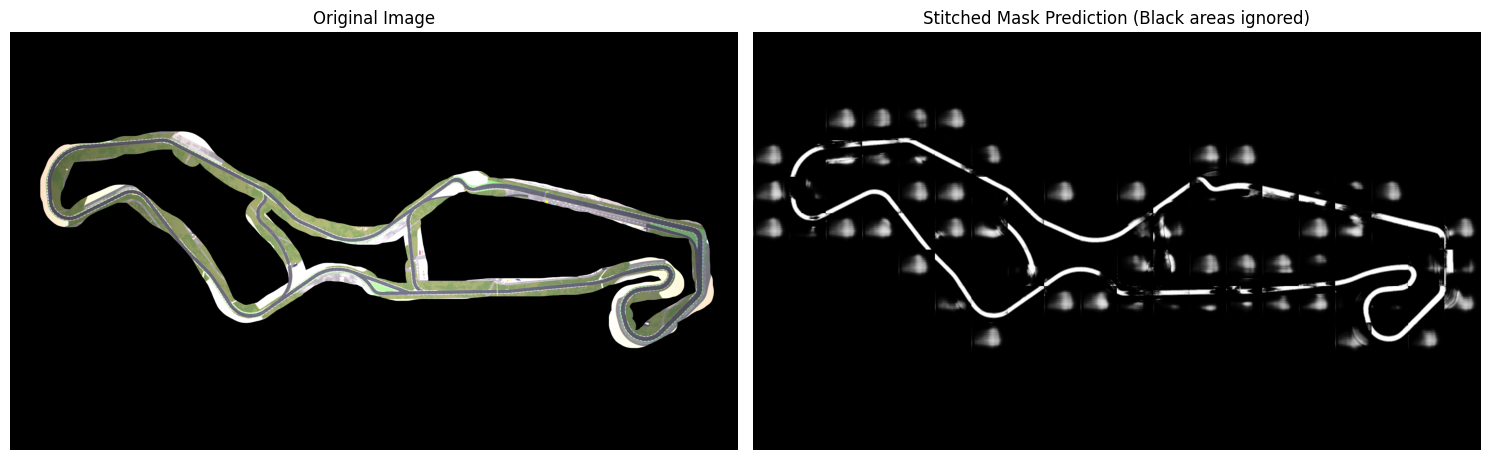

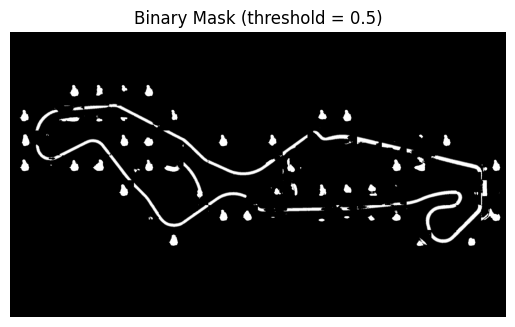

In [90]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)  # Use compile=True to keep original settings

# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """
    Check if a tile should be ignored based on black color percentage.
    
    Args:
        tile_array: numpy array of the tile (H, W, 3)
        black_threshold: percentage of black pixels required to ignore tile (0.0 to 1.0)
        black_color: RGB tuple for the black color to ignore (default: #000000)
    
    Returns:
        bool: True if tile should be ignored, False otherwise
    """
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    # Create mask for black pixels
    black_mask = np.all(tile_array == black_color, axis=-1)
    
    # Calculate percentage of black pixels
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

# Step 4: Modified tile_image function to filter black tiles
def tile_image(image, tile_size=(128, 128), black_threshold=1.0):
    """
    Splits an image into tiles of given size, filtering out predominantly black tiles.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []  # Store coordinates for stitching
    tile_ignore_mask = []  # Track which tiles should be ignored

    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # Crop tile
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            # If tile is smaller, pad it
            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            
            # Check if tile should be ignored
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                # For ignored tiles, we'll still need placeholder coordinates
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

# Load original image
original_image = Image.open(IMAGE_PATH).convert("RGB")

# Generate tiles with black filtering
tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128), black_threshold=1.0)

print(f"Total tiles: {len(tile_coordinates)}")
print(f"Tiles to process: {len(tiles)}")
print(f"Tiles ignored (black): {sum(ignore_mask)}")

# Show the first non-ignored tile if available
if len(tiles) > 0:
    plt.imshow(tiles[0])
    plt.title("First Non-Ignored Tile")
    plt.axis("off")
    plt.show()
else:
    print("All tiles were ignored!")

# Step 5: Predict on all non-ignored tiles with proper preprocessing
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    # Convert to float and normalize to [0, 1]
    tile = tile.astype(np.float32) / 255.0
    return tile

predictions = []
tile_index = 0

for i, ignore in enumerate(ignore_mask):
    if ignore:
        # Create a blank prediction for ignored tiles (all zeros)
        blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
        predictions.append(blank_prediction)
    else:
        # Process and predict on non-ignored tiles
        processed_tile = preprocess_tile(tiles[tile_index])
        prediction = model.predict(np.expand_dims(processed_tile, axis=0))
        predictions.append(prediction[0])  # Remove batch dimension
        tile_index += 1

# Step 6: Visualization function
def visualize_results(predicted_mask, original_image):
    predicted_mask = np.squeeze(predicted_mask)
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Tile')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Show results for first non-ignored tile if available
if len(tiles) > 0:
    first_non_ignored_idx = next((i for i, ignore in enumerate(ignore_mask) if not ignore), None)
    if first_non_ignored_idx is not None:
        visualize_results(predictions[first_non_ignored_idx], 
                         tiles[first_non_ignored_idx - sum(ignore_mask[:first_non_ignored_idx])])

# Step 7: Modified stitch function to handle ignored tiles
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    Handles ignored tiles by leaving those areas blank (0).
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        # Extract the mask from prediction
        if prediction.ndim == 3:  # (H, W, 1)
            mask = prediction[:, :, 0]
        else:  # (H, W)
            mask = prediction
        
        # Determine actual tile dimensions (for edge tiles)
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        # Place the tile in the stitched image
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched

# Step 8: Stitch predictions back into full mask
original_size = original_image.size  # (width, height)
stitched_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))

# Step 9: Show stitched result
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask Prediction (Black areas ignored)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the result
stitched_mask_image = (stitched_mask * 255).astype(np.uint8)
Image.fromarray(stitched_mask_image).save('predicted_mask.png')

# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (threshold = 0.5)')
plt.axis('off')
plt.show()

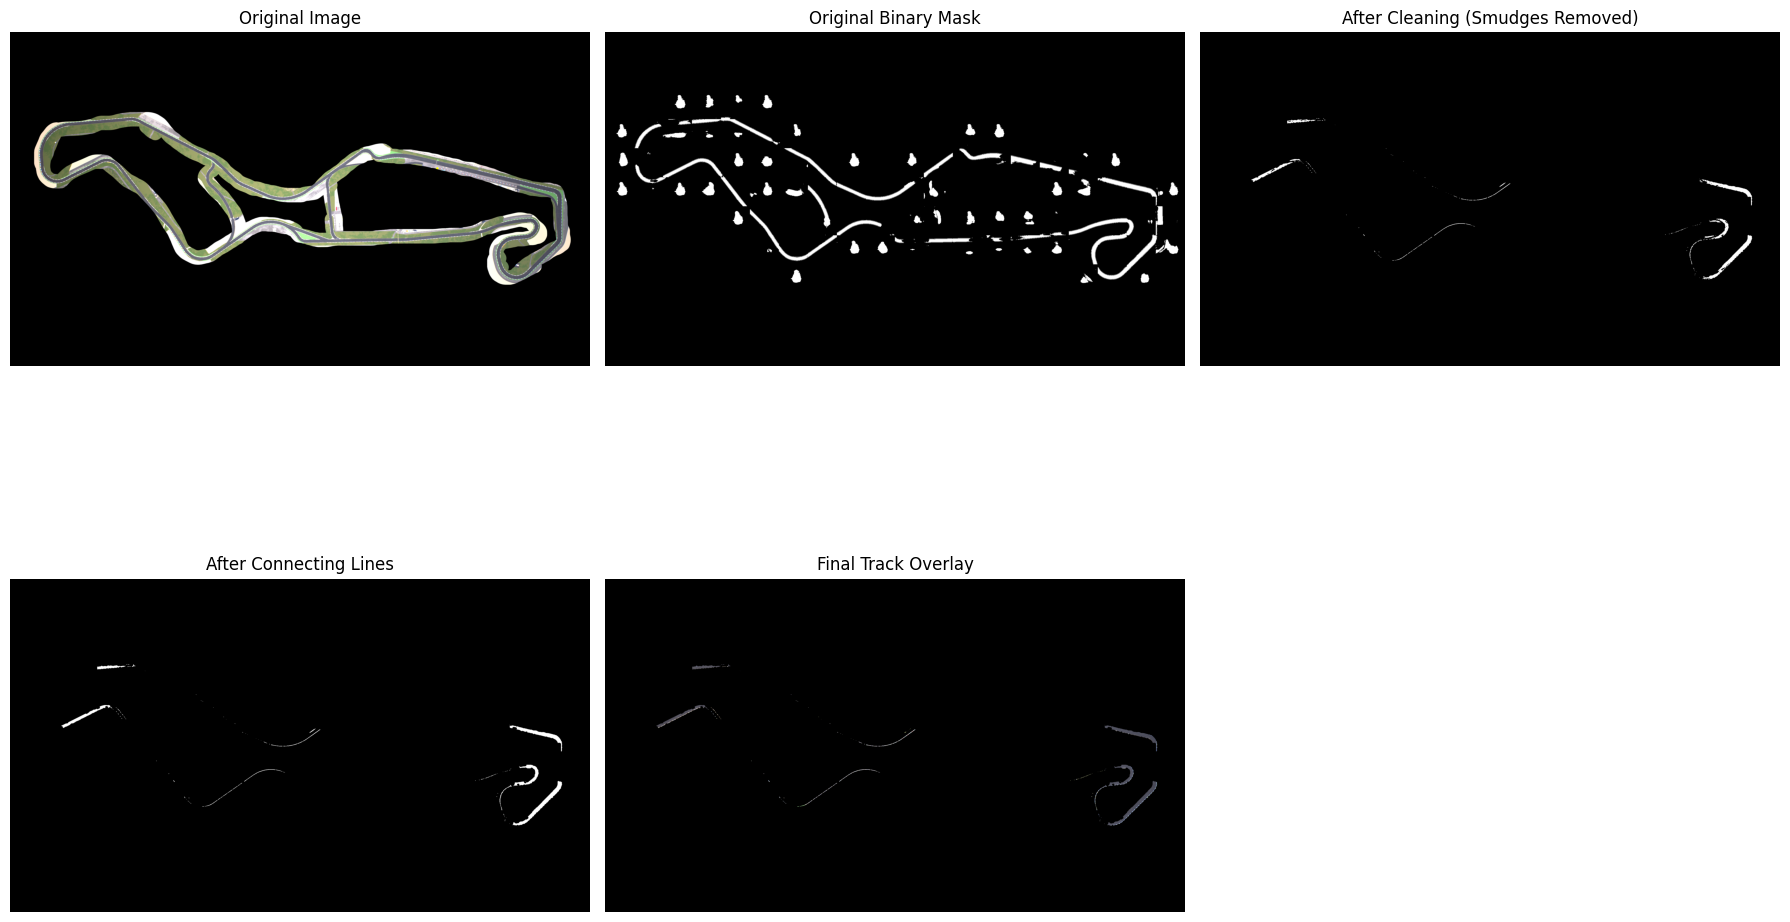

In [100]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
from scipy import ndimage

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)

# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """
    Check if a tile should be ignored based on black color percentage.
    """
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    # Create mask for black pixels
    black_mask = np.all(tile_array == black_color, axis=-1)
    
    # Calculate percentage of black pixels
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

# Step 4: Modified tile_image function to filter black tiles
def tile_image(image, tile_size=(128, 128), black_threshold=1.0):
    """
    Splits an image into tiles of given size, filtering out predominantly black tiles.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # Crop tile
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            # If tile is smaller, pad it
            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            
            # Check if tile should be ignored
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                # For ignored tiles, we'll still need placeholder coordinates
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

# Load original image
original_image = Image.open(IMAGE_PATH).convert("RGB")

# Generate tiles with black filtering
tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128), black_threshold=1.0)

print(f"Total tiles: {len(tile_coordinates)}")
print(f"Tiles to process: {len(tiles)}")
print(f"Tiles ignored (black): {sum(ignore_mask)}")

# Step 5: Predict on all non-ignored tiles with proper preprocessing
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    tile = tile.astype(np.float32) / 255.0
    return tile

# NEW: Function to post-process predictions to reduce false positives
def postprocess_prediction(prediction, confidence_threshold=0.7, min_size=50):
    """
    Clean up predictions by applying thresholding and removing small artifacts.
    """
    # Apply confidence threshold
    binary_mask = (prediction > confidence_threshold).astype(np.uint8)
    
    # Remove small objects (noise)
    cleaned_mask = ndimage.binary_opening(binary_mask, structure=np.ones((3,3)))
    
    # Remove small connected components
    labeled_mask, num_features = ndimage.label(cleaned_mask)
    component_sizes = np.bincount(labeled_mask.ravel())
    
    # Keep only components larger than min_size
    size_mask = component_sizes >= min_size
    size_mask[0] = 0  # Keep background (label 0)
    cleaned_mask = size_mask[labeled_mask]
    
    # Convert back to float and apply smoothing
    cleaned_float = cleaned_mask.astype(np.float32)
    
    # Apply Gaussian smoothing to reduce hard edges
    cleaned_float = ndimage.gaussian_filter(cleaned_float, sigma=0.5)
    
    return cleaned_float

predictions = []
tile_index = 0

for i, ignore in enumerate(ignore_mask):
    if ignore:
        # Create a blank prediction for ignored tiles (all zeros)
        blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
        predictions.append(blank_prediction)
    else:
        # Process and predict on non-ignored tiles
        processed_tile = preprocess_tile(tiles[tile_index])
        prediction = model.predict(np.expand_dims(processed_tile, axis=0), verbose=0)[0]
        
        # NEW: Apply post-processing to clean up the prediction
        cleaned_prediction = postprocess_prediction(np.squeeze(prediction))
        
        # Reshape back to (128, 128, 1)
        predictions.append(cleaned_prediction[:, :, np.newaxis])
        tile_index += 1

# Step 6: Stitch predictions back into full mask
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        # Extract the mask from prediction
        if prediction.ndim == 3:  # (H, W, 1)
            mask = prediction[:, :, 0]
        else:  # (H, W)
            mask = prediction
        
        # Determine actual tile dimensions (for edge tiles)
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        # Place the tile in the stitched image
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched

original_size = original_image.size
stitched_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))

# NEW: Apply global post-processing to the entire stitched mask
def postprocess_global_mask(mask, confidence_threshold=0.5, min_track_size=500):
    """
    Apply global post-processing to the entire mask to clean up artifacts
    and ensure consistency across tile boundaries.
    """
    # Apply threshold
    binary_mask = (mask > confidence_threshold).astype(np.uint8)
    
    # Morphological operations to clean up the mask
    kernel = np.ones((5,5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)
    
    # Remove small isolated components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned_mask, 8, cv2.CV_32S)
    
    # Find the largest component (likely the track)
    if num_labels > 1:
        largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        final_mask = (labels == largest_component).astype(np.uint8)
    else:
        final_mask = cleaned_mask
    
    # Smooth the edges
    final_mask = cv2.GaussianBlur(final_mask.astype(np.float32), (5, 5), 0)
    
    return final_mask

# Apply global post-processing
final_mask = postprocess_global_mask(stitched_mask)

# Step 7: Show results
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Raw Stitched Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Cleaned Final Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

# # Save the cleaned result
# final_mask_image = (final_mask * 255).astype(np.uint8)
# Image.fromarray(final_mask_image).save('cleaned_predicted_mask.png')

# Optional: Overlay the mask on the original image
overlay = np.array(original_image).copy()
overlay[final_mask > 0.5] = [255, 0, 0]  # Highlight track in red

plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.title('Track Overlay on Original Image')
plt.axis('off')
plt.show()

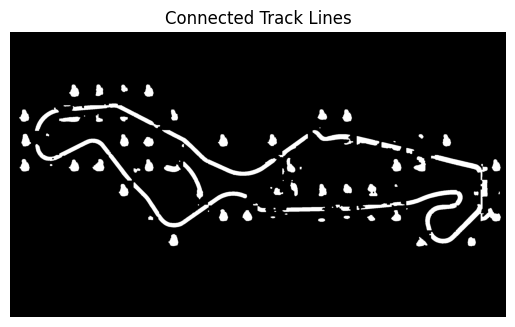

In [94]:
def advanced_connect_track_lines(binary_mask):
    """
    More sophisticated approach to connect track lines using morphological operations.
    """
    binary_mask_uint8 = binary_mask.astype(np.uint8) * 255
    
    # Create a larger kernel for better connection
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Close small gaps
    closed = cv2.morphologyEx(binary_mask_uint8, cv2.MORPH_CLOSE, kernel)
    
    # Optional: Use distance transform to find connection points
    dist_transform = cv2.distanceTransform(closed, cv2.DIST_L2, 5)
    
    # Threshold the distance transform to get skeleton points
    _, skeleton = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    skeleton = skeleton.astype(np.uint8)
    
    return skeleton // 255

connected_mask = advanced_connect_track_lines(binary_mask)

# Apply connection after your existing code
connected_mask = connect_track_lines(binary_mask)

plt.imshow(connected_mask, cmap='gray')
plt.title('Connected Track Lines')
plt.axis('off')
plt.show()

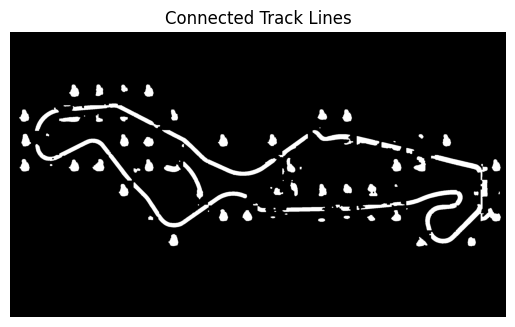

In [95]:
def connect_with_hough_lines(binary_mask):
    """
    Use Hough Line Transform to detect and connect lines.
    """
    binary_mask_uint8 = binary_mask.astype(np.uint8) * 255
    
    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(binary_mask_uint8, 1, np.pi/180, threshold=50, 
                           minLineLength=30, maxLineGap=20)
    
    # Create a blank canvas
    connected = np.zeros_like(binary_mask_uint8)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(connected, (x1, y1), (x2, y2), 255, 2)
    
    return connected // 255

connected_mask = connect_with_hough_lines(binary_mask)

# Apply connection after your existing code
connected_mask = connect_track_lines(binary_mask)

plt.imshow(connected_mask, cmap='gray')
plt.title('Connected Track Lines')
plt.axis('off')
plt.show()

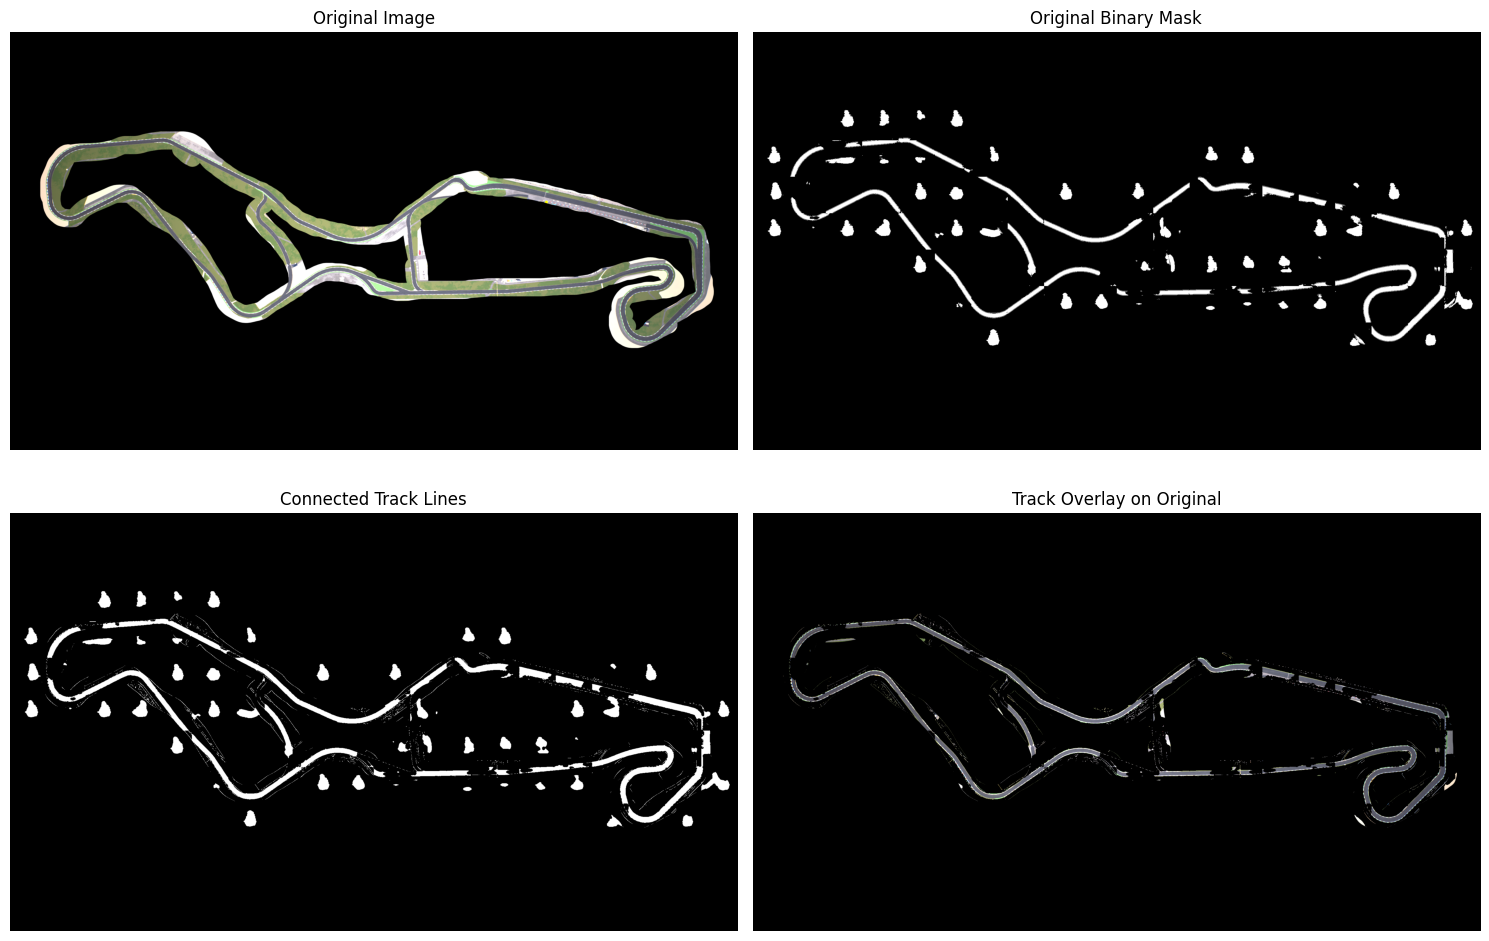

In [97]:
# After your existing code...
# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)

# Connect the track lines
def connect_track_lines_optimized(binary_mask, original_image=None):
    """
    Optimized function to connect track lines with multiple techniques.
    """
    binary_mask_uint8 = binary_mask.astype(np.uint8) * 255
    
    # Method 1: Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    connected = cv2.morphologyEx(binary_mask_uint8, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Method 2: Optional - use original image info if available
    if original_image is not None:
        # Convert original image to grayscale for edge detection
        gray_original = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray_original, 50, 150)
        
        # Combine with our mask (OR operation)
        connected = cv2.bitwise_or(connected, edges)
    
    # Method 3: Final smoothing
    connected = cv2.medianBlur(connected, 3)
    
    return connected // 255

# Use the original image to help with connection
connected_mask = connect_track_lines_optimized(binary_mask, original_image)

# Visualize results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Original Binary Mask')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(connected_mask, cmap='gray')
plt.title('Connected Track Lines')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.bitwise_and(np.array(original_image), np.array(original_image), 
                          mask=connected_mask.astype(np.uint8) * 255))
plt.title('Track Overlay on Original')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save connected mask
connected_mask_image = (connected_mask * 255).astype(np.uint8)
Image.fromarray(connected_mask_image).save('connected_track_mask.png')

Total tiles: 252
Tiles to process: 113
Tiles ignored (pink): 139


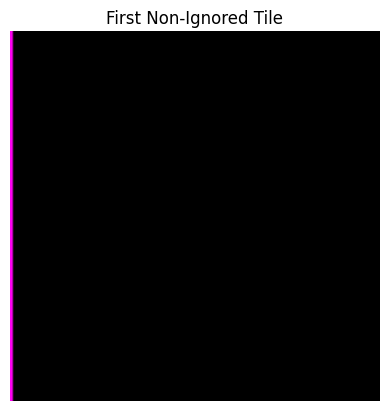

In [75]:
# Load original image
original_image = Image.open(IMAGE_PATH).convert("RGB")

# Generate tiles with pink filtering
tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128), pink_threshold=1.0)

print(f"Total tiles: {len(tile_coordinates)}")
print(f"Tiles to process: {len(tiles)}")
print(f"Tiles ignored (pink): {sum(ignore_mask)}")

# Show the first non-ignored tile if available
if len(tiles) > 0:
    plt.imshow(tiles[0])
    plt.title("First Non-Ignored Tile")
    plt.axis("off")
    plt.show()
else:
    print("All tiles were ignored!")

In [76]:
# Step 5: Predict on all non-ignored tiles with proper preprocessing
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    # Convert to float and normalize to [0, 1]
    tile = tile.astype(np.float32) / 255.0
    return tile

predictions = []
tile_index = 0

for i, ignore in enumerate(ignore_mask):
    if ignore:
        # Create a blank prediction for ignored tiles (all zeros)
        blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
        predictions.append(blank_prediction)
    else:
        # Process and predict on non-ignored tiles
        processed_tile = preprocess_tile(tiles[tile_index])
        prediction = model.predict(np.expand_dims(processed_tile, axis=0))
        predictions.append(prediction[0])  # Remove batch dimension
        tile_index += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

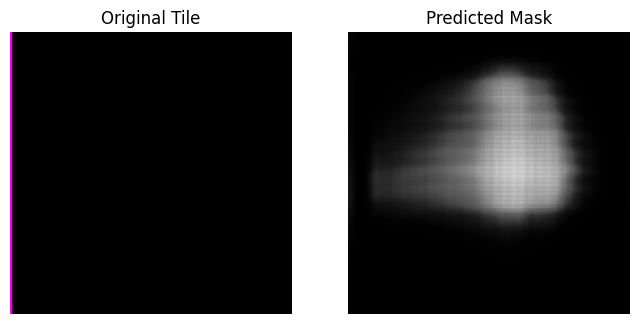

In [77]:
# Step 6: Visualization function
def visualize_results(predicted_mask, original_image):
    predicted_mask = np.squeeze(predicted_mask)
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Tile')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Show results for first non-ignored tile if available
if len(tiles) > 0:
    first_non_ignored_idx = next((i for i, ignore in enumerate(ignore_mask) if not ignore), None)
    if first_non_ignored_idx is not None:
        visualize_results(predictions[first_non_ignored_idx], 
                         tiles[first_non_ignored_idx - sum(ignore_mask[:first_non_ignored_idx])])


In [78]:
# Step 7: Modified stitch function to handle ignored tiles
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    Handles ignored tiles by leaving those areas blank (0).
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        # Extract the mask from prediction
        if prediction.ndim == 3:  # (H, W, 1)
            mask = prediction[:, :, 0]
        else:  # (H, W)
            mask = prediction
        
        # Determine actual tile dimensions (for edge tiles)
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        # Place the tile in the stitched image
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched

In [79]:
# Step 8: Stitch predictions back into full mask
original_size = original_image.size  # (width, height)
stitched_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))

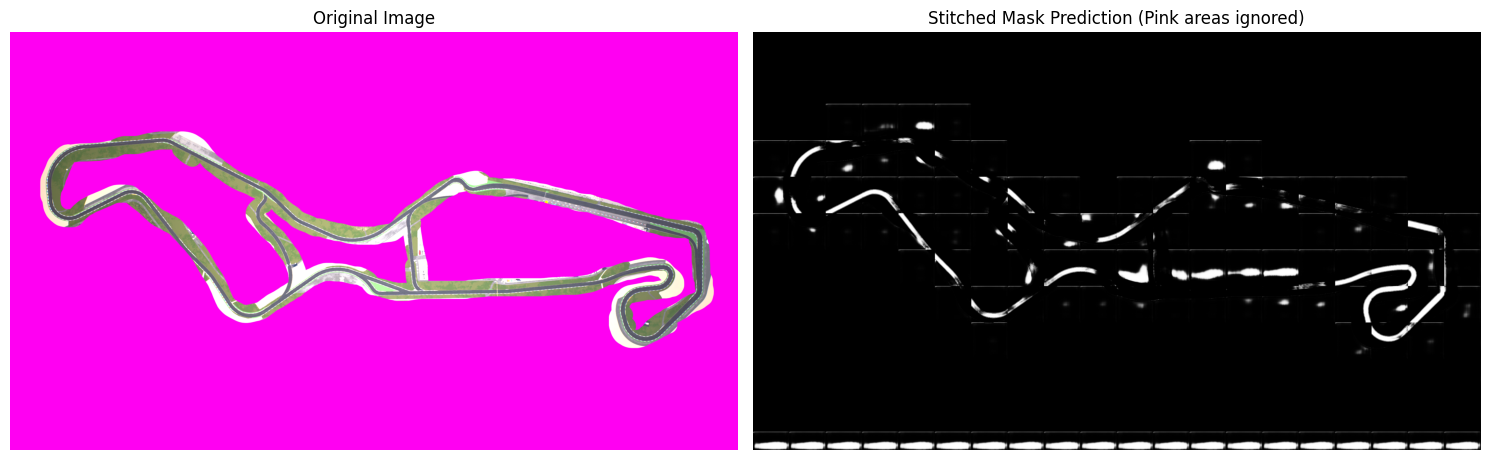

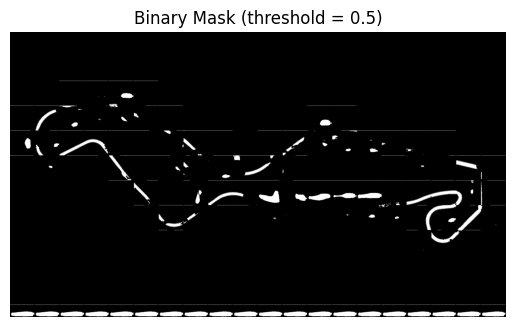

In [80]:
# Step 9: Show stitched result
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask Prediction (Pink areas ignored)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the result
stitched_mask_image = (stitched_mask * 255).astype(np.uint8)
Image.fromarray(stitched_mask_image).save('predicted_mask.png')

# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (threshold = 0.5)')
plt.axis('off')
plt.show()

In [81]:
def stitch_tiles(tiles, image_size, tile_size=(128, 128)):
    """
    Stitches a list of tiles back into the original image size.

    Args:
        tiles (list of np.ndarray): List of tiles (predictions or images).
        image_size (tuple): (width, height) of the original image.
        tile_size (tuple): Size of each tile (width, height).

    Returns:
        np.ndarray: Stitched image.
    """
    width, height = image_size
    stitched = np.zeros((height, width), dtype=np.float32)  # for mask, 1 channel

    tile_idx = 0
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            tile = tiles[tile_idx]

            # Ensure tile is 2D (mask only)
            if tile.ndim == 4:  # (1, H, W, 1)
                tile = tile[0, :, :, 0]
            elif tile.ndim == 3 and tile.shape[-1] == 1:  # (H, W, 1)
                tile = tile[:, :, 0]

            h = min(tile_size[1], height - y)
            w = min(tile_size[0], width - x)

            stitched[y:y+h, x:x+w] = tile[:h, :w]
            tile_idx += 1

    return stitched


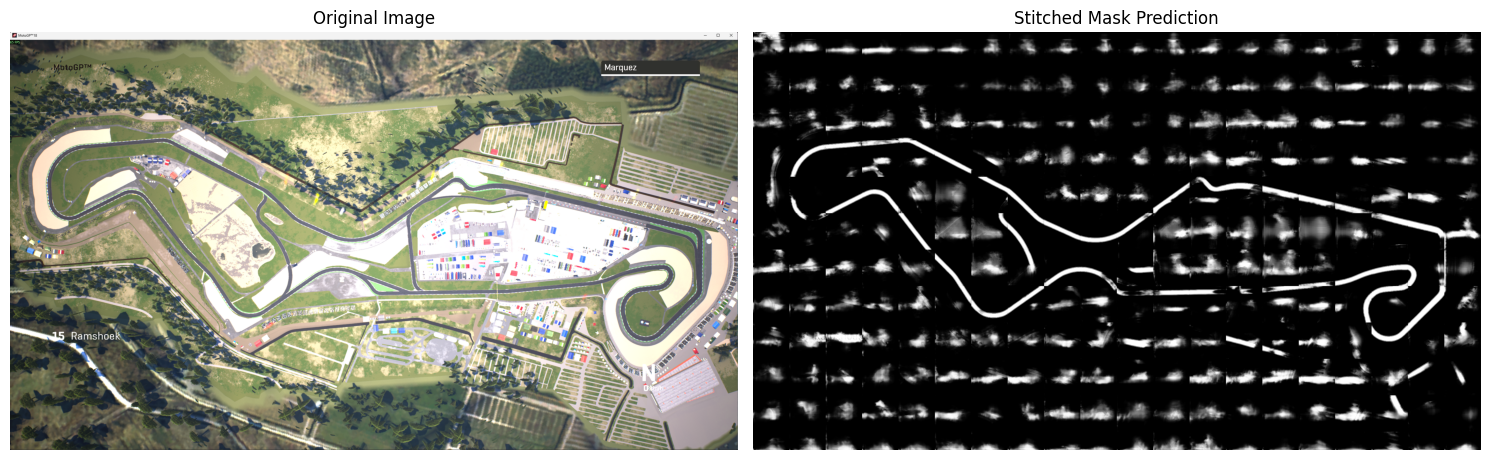

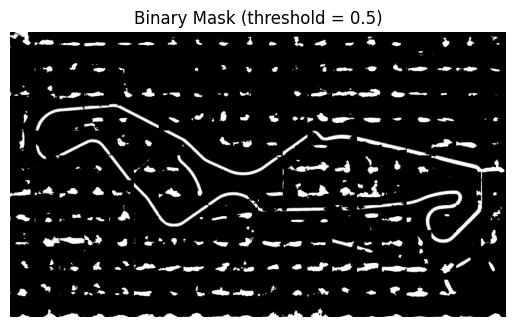

In [12]:
# Step 10: Show stitched result
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the result
stitched_mask_image = (stitched_mask * 255).astype(np.uint8)
Image.fromarray(stitched_mask_image).save('predicted_mask.png')

# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (threshold = 0.5)')
plt.axis('off')
plt.show()

In [13]:
def tile_image_large(image, crop_size=(246, 246), model_input_size=(128, 128)):
    """
    Splits an image into larger tiles and resizes them for the model.

    Args:
        image (PIL.Image or np.ndarray): Input image.
        crop_size (tuple): (width, height) of the crop from original image.
        model_input_size (tuple): Size to resize for the model.

    Returns:
        list: List of resized tiles (for model).
        list: List of original-sized tiles (for later upscaling mask).
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    resized_tiles = []
    original_tiles = []

    for y in range(0, height, crop_size[1]):
        for x in range(0, width, crop_size[0]):
            # Crop larger tile
            tile = image.crop((x, y, x + crop_size[0], y + crop_size[1]))

            # Pad if smaller
            if tile.size != crop_size:
                new_tile = Image.new("RGB", crop_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            original_tiles.append(np.array(tile))  # Save original crop size
            resized_tile = tile.resize(model_input_size, Image.BILINEAR)
            resized_tiles.append(np.array(resized_tile))

    return resized_tiles, original_tiles


In [14]:
# Load and create tiles
resized_tiles, original_tiles = tile_image_large(original_image, crop_size=(246, 246), model_input_size=(128, 128))

predictions = []
for tile in resized_tiles:
    tile_input = np.expand_dims(tile, axis=0)
    pred = model.predict(tile_input, verbose=0)
    # Upscale back to crop size for stitching
    pred_upscaled = Image.fromarray(np.squeeze(pred) * 255).resize((246, 246), Image.BILINEAR)
    pred_upscaled = np.array(pred_upscaled) / 255.0
    predictions.append(pred_upscaled)


In [15]:
def stitch_tiles_large(tiles, image_size, crop_size=(246, 246)):
    width, height = image_size
    stitched = np.zeros((height, width), dtype=np.float32)

    tile_idx = 0
    for y in range(0, height, crop_size[1]):
        for x in range(0, width, crop_size[0]):
            h = min(crop_size[1], height - y)
            w = min(crop_size[0], width - x)
            stitched[y:y+h, x:x+w] = tiles[tile_idx][:h, :w]
            tile_idx += 1

    return stitched

stitched_mask = stitch_tiles_large(predictions, original_image.size, crop_size=(246, 246))


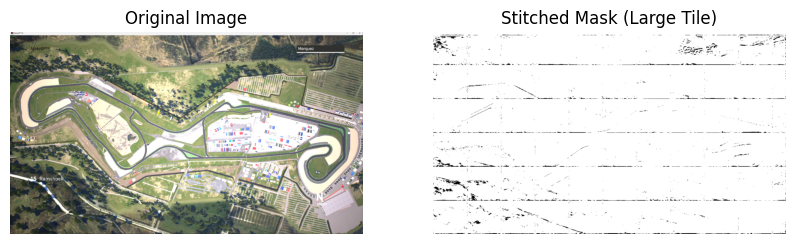

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask (Large Tile)')
plt.axis('off')
plt.show()
